<a href="https://colab.research.google.com/github/gguedes00/Transfer-Learning/blob/main/desafio_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow_datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

BATCH_SIZE = 64
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Saída binária (0=cat, 1=dog)
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 996s 3s/step - accuracy: 0.9304 - loss: 0.1872 - val_accuracy: 0.9875 - val_loss: 0.0405
Epoch 2/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 957s 3s/step - accuracy: 0.9879 - loss: 0.0398 - val_accuracy: 0.9888 - val_loss: 0.0341


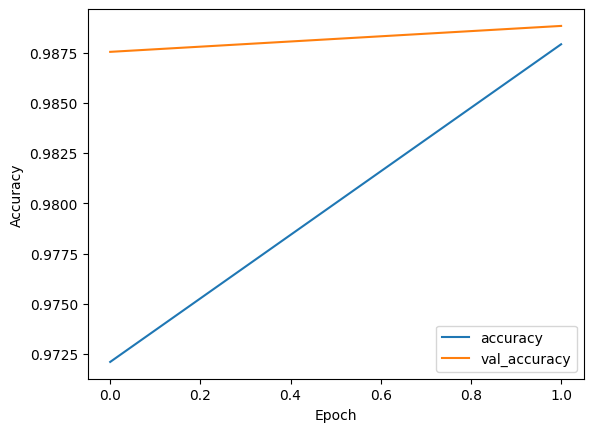

In [ ]:
history = model.fit(
    ds_train,
    epochs=2,
    validation_data=ds_test
)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history_fine = model.fit(
    ds_train,
    epochs=2,
    validation_data=ds_test
)

Epoch 1/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 1453s 5s/step - accuracy: 0.9408 - loss: 0.1472 - val_accuracy: 0.9834 - val_loss: 0.0507
Epoch 2/2
291/291 ━━━━━━━━━━━━━━━━━━━━ 1452s 5s/step - accuracy: 0.9842 - loss: 0.0455 - val_accuracy: 0.9856 - val_loss: 0.0425


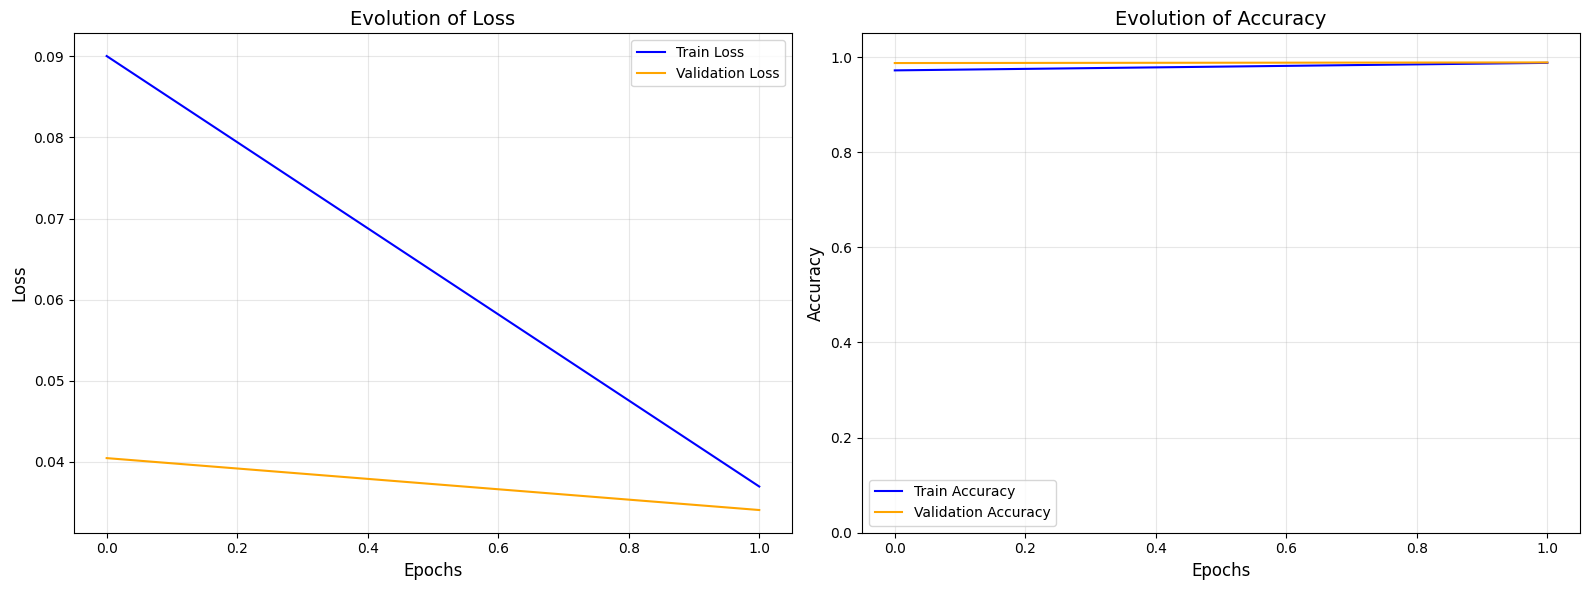

In [ ]:
fig = plt.figure(figsize=(16, 6))

ax = fig.add_subplot(121)
ax.plot(history.history["loss"], color='blue', label='Train Loss')
ax.plot(history.history["val_loss"], color='orange', label='Validation Loss')
ax.set_title("Evolution of Loss", fontsize=14)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.grid(alpha=0.3)
ax.legend()

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"], color='blue', label='Train Accuracy')
ax2.plot(history.history["val_accuracy"], color='orange', label='Validation Accuracy')
ax2.set_title("Evolution of Accuracy", fontsize=14)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_ylim(0, 1.05)
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('meu_modelo.keras')